## Project 01

## Loading Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check to See if CUDA Available or Not

In [2]:
import torch
# Place the model on the GPU (if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
else:
    print(device)

GeForce 920MX


## Import the necessary modules

In [3]:
# Import the necessary modules
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

## Define the model class EfficientNet

In [4]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            Swish(),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, reduction=4, drop_connect_rate=0.2):
        super(MBConv, self).__init__()
        self.use_residual = (in_channels == out_channels and stride == 1)
        hidden_dim = round(in_channels * expand_ratio)
        self.expand_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.expand_bn = nn.BatchNorm2d(hidden_dim)
        self.dw_conv = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride, padding=(kernel_size - 1) // 2, groups=hidden_dim, bias=False)
        self.dw_bn = nn.BatchNorm2d(hidden_dim)
        self.se = SEBlock(hidden_dim, reduction)
        self.project_conv = nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False)
        self.project_bn = nn.BatchNorm2d(out_channels)
        self.drop_connect_rate = drop_connect_rate

    def _drop_connect(self, x):
        if not self.training:
            return x
        keep_prob = 1 - self.drop_connect_rate
        mask = torch.rand(x.size(0), 1, 1, 1, device=x.device) + keep_prob
        mask = mask.floor()
        return x / keep_prob * mask

    def forward(self, x):
        y = self.expand_bn(self.expand_conv(x))
        y = Swish()(y)
        y = self.dw_bn(self.dw_conv(y))
        y = self.se(y)
        y = Swish()(self.project_bn(self.project_conv(y)))
        if self.use_residual:
            y = self._drop_connect(y)
            y += x
        return y


class EfficientNet(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0, depth_mult=1.0, resolution_mult=1.0, dropout_rate=0.2, drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()
        settings = [
            # t, c, n, s, k
            [1, 16, 1, 1, 3],
            [6, 24, 2, 2, 3],
            [6, 40, 2, 2, 5],
            [6, 80, 3, 2, 3],
            [6, 112, 3, 1, 5],
            [6, 192, 4, 2, 5],
            [6, 320, 1, 1, 3]
        ]
        out_channels = int(32 * width_mult)
        self.features = nn.Sequential(
            nn.Conv2d(3, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            Swish(),
        )
        in_channels = out_channels
        for i, (t, c, n, s, k) in enumerate(settings):
            out_channels = int(c * width_mult)
            depth = int(math.ceil(depth_mult * n))
            for j in range(depth):
                if j == 0:
                    stride = s
                else:
                    stride = 1
                drop_connect = drop_connect_rate * (i * depth + j) / (len(settings) * depth)
                self.features.add_module(f'mbconv{i+1}_{j+1}', MBConv(in_channels, out_channels, k, stride, t, drop_connect_rate=drop_connect))
                in_channels = out_channels
        last_channels = int(1280 * width_mult)
        self.features.add_module('conv9', nn.Conv2d(in_channels, last_channels, kernel_size=1, bias=False))
        self.features.add_module('bn9', nn.BatchNorm2d(last_channels))
        self.features.add_module('swish9', Swish())
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x


## An instance of the model

In [5]:
# Create an instance of the model
model = EfficientNet()

## Sending model weights to the GPU

In [6]:
# send your model weights to the GPU
if torch.cuda.is_available():
    model.cuda()
    model.to(torch.device('cuda'))
    print ("Model weights are on the GPU")

# Check if CUDA is available
if torch.cuda.is_available():
    # Use the GPU
    device = torch.device("cuda")
    print (device)
else:
    # Use the CPU
    device = torch.device("cpu")
    print (device)


Model weights are on the GPU
cuda


## Define the loss function and the optimizer

In [51]:
# Define the loss function and the optimizer

# Cross entropy loss function for multi-class classification
criterion = nn.CrossEntropyLoss() 
# Stochastic gradient descent optimizer with learning rate of 0.01
optimizer = optim.SGD(model.parameters(), lr=0.1) 

In [10]:
# Define the loss function and the optimizer

# Cross entropy loss function for multi-class classification
criterion = nn.CrossEntropyLoss() 
# A Method for Stochastic Optimization
optimizer = torch.optim.Adam(model.parameters(), lr=0.04)

## Dataset and Data Loader

In [11]:
# Define the file path to save the model
PATH = "D:\Mamad\S.B.UK.AC.IR\Docs\M.Eng.in.ST\Courses\Deep.Learning\HomeWorks\HW03\model.cifar10.pth"
# PATH = "model.pth"

# Define the Directory path to save the Dataset
PATH_DIR_DATA = "D:\Mamad\S.B.UK.AC.IR\Docs\M.Eng.in.ST\Courses\Deep.Learning\HomeWorks\HW03\data\CIFAR10"

# Check if the file exists
if os.path.isfile(PATH):
    # Load the saved model state dictionary
    model.load_state_dict(torch.load(PATH))
    print("Loaded model from:", PATH)

else:
    print("No saved model found. Starting with a new model.")

# Define the transforms for pre-processing and data augmentation
transform = transforms.Compose([
    transforms.ToTensor(), # Convert the data into tensor
    # transforms.RandomRotation(90), # Rotate the data randomly by 90 degrees
    # transforms.Normalize((0,), (0.5,))
])

# Load the CIFAR10 dataset
cifar10_data = datasets.CIFAR10(root=PATH_DIR_DATA, download=True, transform=transform)

# Split the dataset into train, test and cross validation sets
train_size = int(0.8 * len(cifar10_data)) # 80% of the data for training
test_size = int(0.1 * len(cifar10_data)) # 10% of the data for testing
val_size = len(cifar10_data) - train_size - test_size # 10% of the data for cross validation
train_data, test_data, val_data = torch.utils.data.random_split(cifar10_data, [train_size, test_size, val_size])

# Create data loaders for the train, validation and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) # Batch size of 64 and shuffle the data
val_loader = DataLoader(val_data, batch_size=32, shuffle=False) # Batch size of 64 and do not shuffle the data
test_loader = DataLoader(test_data, batch_size=32, shuffle=False) # Batch size of 64 and do not shuffle the data

Loaded model from: D:\Mamad\S.B.UK.AC.IR\Docs\M.Eng.in.ST\Courses\Deep.Learning\HomeWorks\HW03\model.cifar10.pth
Files already downloaded and verified


## Training The Model on the Train set and Cross-Validation set

In [ ]:
# Define the number of epochs
epochs = 5

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
test_loss_list = []
test_acc_list = []

train_loss_list = [0] * epochs
train_acc_list = [0] * epochs

val_loss_list = [0] * epochs
val_acc_list = [0] * epochs

test_loss_list = [0] * epochs
test_acc_list = [0] * epochs

# Write a loop to iterate over the data and update the model parameters
for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    # Initialize the training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0
    # Loop over the training batches
    for images, labels in train_loader:
        # Move the data to the device (CPU or GPU)
        images = images.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update the training loss and accuracy
        train_loss += loss.item()
        train_acc += (outputs.argmax(dim=1) == labels).sum().item()
    # Calculate the average training loss and accuracy per epoch
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_data)
    # Add values to respective lists
    train_loss_list [epoch] = (train_loss)
    train_acc_list [epoch] = (train_acc)
    # Print the training statistics
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {100*train_acc:.4f}%')

    # Set the model to evaluation mode
    model.eval()
    # Initialize the validation loss and accuracy
    val_loss = 0.0
    val_acc = 0.0
    # Loop over the validation batches
    with torch.no_grad(): # No need to track gradients for validation
        for images, labels in val_loader:
            # Move the data to the device (CPU or GPU)
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Update the validation loss and accuracy
            val_loss += loss.item()
            val_acc += (outputs.argmax(dim=1) == labels).sum().item()
    # Calculate the average validation loss and accuracy per epoch
    val_loss = val_loss / len(val_loader)
    val_acc = val_acc / len(val_data)
    val_loss_list [epoch] = val_loss
    val_acc_list [epoch] = val_acc
    # Print the validation statistics
    print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {100*val_acc:.4f}%')
    # Save model parameters and weights
    torch.save(model.state_dict(), PATH)

## Saving Model

In [95]:
import torch
torch.save(model.state_dict(), PATH)
# torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.cifar.pth")

Saved PyTorch Model State to model.cifar.pth


## Test the Model on the Test set

In [64]:
# Set the model to evaluation mode
model.eval()
# Initialize the test loss and accuracy
test_loss = 0.0
test_acc = 0.0
# Loop over the test batches
with torch.no_grad(): # No need to track gradients for testing
    for images, labels in test_loader:
        # Move the data to the device 
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Update the test loss and accuracy
        test_loss += loss.item()
        test_acc += (outputs.argmax(dim=1) == labels).sum().item()
# Calculate the average test loss and accuracy
test_loss = test_loss / len(test_loader)
test_acc = test_acc / len(test_data)
# Print the test statistics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {100*test_acc:.4f}%')


Test Loss: 257702451704444697981476315070464.0000, Test Accuracy: 10.3800%


## Total number of Parameters

In [14]:
# Get the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Get the total number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the total number and trainable parameters
print(f' Total Params: {total_params:.4f}, Trainable Params: {trainable_params:.4f}') 

 Total Params: 7156746.0000, Trainable Params: 7156746.0000


In [15]:
import torch
from torchsummary import summary
summary(model.cuda(), (3 ,32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             Swish-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           1,024
       BatchNorm2d-5           [-1, 32, 16, 16]              64
            Conv2d-6           [-1, 32, 16, 16]             288
       BatchNorm2d-7           [-1, 32, 16, 16]              64
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Linear-9                    [-1, 8]             264
            Swish-10                    [-1, 8]               0
           Linear-11                   [-1, 32]             288
          Sigmoid-12                   [-1, 32]               0
          SEBlock-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 16,

## Ploting Loss and Accuracy

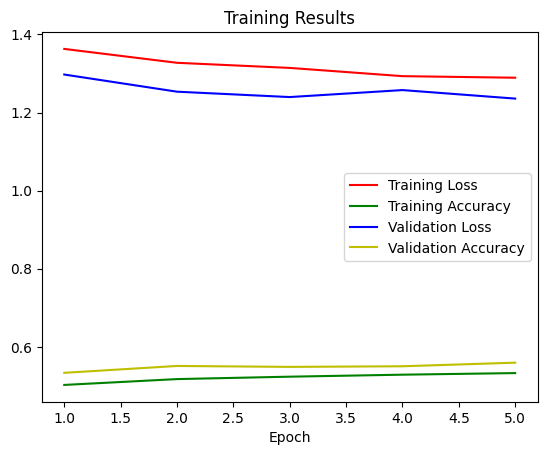

In [96]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the results
epochs = range(1, epochs+1)
plt.plot(epochs, train_loss_list, 'r', label='Training Loss')
plt.plot(epochs, train_acc_list, 'g', label='Training Accuracy')
plt.plot(epochs, val_loss_list, 'b', label='Validation Loss')
plt.plot(epochs, val_acc_list, 'y', label='Validation Accuracy')
# plt.plot(test_loss_list, 'c', label='Test Loss')
# plt.plot(test_acc_list, 'm', label='Test Accuracy')
plt.title('Training Results')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Load the Model

In [97]:
model = EfficientNet()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Make a Prediction on the Test set

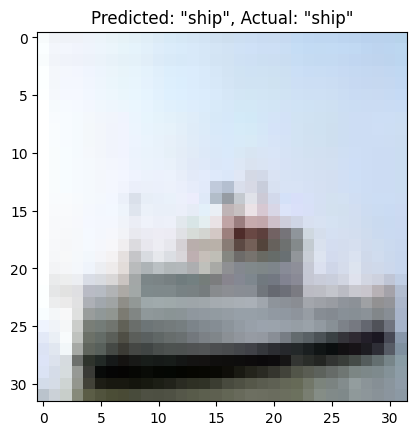

In [103]:
import matplotlib.pyplot as plt

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

model.eval()
num = 8
images, labels = test_data[num][0], test_data[num][1]
with torch.no_grad():
    pred = model(images.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[labels]
    
    # Plot the image
    plt.imshow(images.permute(1, 2, 0))
    plt.title(f'Predicted: "{predicted}", Actual: "{actual}"')
    plt.show()
